# DeepHit with Competing Risks

In this notebook we give an example of how to apply the [DeepHit](http://medianetlab.ee.ucla.edu/papers/AAAI_2018_DeepHit) method for competing risks.

The `pycox` package has (so far) limited support for competing-risk data, so the evaluation procedure at the end is somewhat limited.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchtuples as tt

from pycox.preprocessing.label_transforms import LabTransDiscreteSurv
from torchtuples.practical import MLPVanilla
from pycox.models import DeepHit
from pycox.evaluation import EvalSurv

In [2]:
np.random.seed(1234)
_ = torch.manual_seed(1234)

## Dataset from the DeepHit repo

We download a competing risk data set from the DeepHit authors repo.
The dataset is from a simulation study with two event types and censored observations.

We split in train, val and test.

In [3]:
url = 'https://raw.githubusercontent.com/chl8856/DeepHit/master/sample%20data/SYNTHETIC/synthetic_comprisk.csv'
df_train = pd.read_csv(url)
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [4]:
df_train.head()

,time,label,true_time,true_label,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12
1,1,0,1,1,0.015579,-0.84608,0.48753,0.65193,0.20099,-0.11238,-1.39630,-0.188740,-0.30001,-0.24032,-0.38533,-1.02450
2,34,2,34,2,0.446490,1.64100,-1.74500,0.31795,-1.14060,0.36560,0.28110,-0.582530,-1.69070,1.20220,-0.51920,1.78400
3,9,0,9,2,0.629460,-0.61575,-0.32345,-0.90020,0.45360,-0.61992,2.16240,0.198750,-1.11960,-2.73210,-0.25673,-0.81836
5,11,2,11,2,0.487010,0.52086,1.99370,-0.94736,0.24371,1.06550,0.57686,0.019192,0.23212,0.48023,-0.73096,1.43960
6,37,0,40,2,-1.183700,-0.31602,-0.58640,-0.53890,-1.15830,1.04010,0.61938,-0.415420,-0.50700,-2.18300,0.97320,0.97753


## Feature transforms

The covariates are standardized, so we don't need to any preprocessing.

In [5]:
get_x = lambda df: (df
                    .drop(columns=['time', 'label', 'true_time', 'true_label'])
                    .values.astype('float32'))

In [6]:
x_train = get_x(df_train)
x_val = get_x(df_val)
x_test = get_x(df_test)

### Label transforms

Currently, the `pycox` package is mainly focused on single-event data, so there is no dedicated label transformer for competing risks. 
So, we make a simple one on our own, based on the the transform for the discrete methods `LabTransDiscreteSurv`.

The class returns durations (as integers) and event types (as integers) where 0 is reserved for censored observations.

We discretize the data to `num_durations` time points, which can be found with `labtrans.cuts`.

In [7]:
class LabTransform(LabTransDiscreteSurv):
    def transform(self, durations, events):
        durations, is_event = super().transform(durations, events > 0)
        events[is_event == 0] = 0
        return durations, events.astype('int64')

In [8]:
num_durations = 10
labtrans = LabTransform(num_durations)
get_target = lambda df: (df['time'].values, df['label'].values)

In [9]:
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))
durations_test, events_test = get_target(df_test)
val = (x_val, y_val)

In [10]:
y_train[0][:6], y_train[1][:6]

(array([0, 2, 0, 1, 1, 1]), array([0, 2, 0, 2, 0, 1]))

In [11]:
labtrans.cuts

array([  0.        ,  21.33333333,  42.66666667,  64.        ,
        85.33333333, 106.66666667, 128.        , 149.33333333,
       170.66666667, 192.        ])

## Network architecture

Under, we describe two networks that can be for competing risks:

The first, `SimpleMLP`, is a regular MLP which outputs a `[batch_size x num_risks x num_durations]`, e.g., `[64, 2, 10]` tensor.

The other, `CauseSpecificNet` is similar to the cause-specific network described in the [DeepHit paper](http://medianetlab.ee.ucla.edu/papers/AAAI_2018_DeepHit).
It has the same output shape as the `SimpleMLP`, but is a little more complex to make.

In [12]:
class SimpleMLP(torch.nn.Module):
    """Simple network structure for competing risks.
    """
    def __init__(self, in_features, num_nodes, num_risks, out_features, batch_norm=True,
                 dropout=None):
        super().__init__()
        self.num_risks = num_risks
        self.mlp = MLPVanilla(in_features, num_nodes, num_risks * out_features,
                              batch_norm, dropout)

    def forward(self, input):
        out = self.mlp(input)
        return out.view(out.size(0), self.num_risks, -1)

In [13]:
class CauseSpecificNet(torch.nn.Module):
    """Network structure similar to the DeepHit paper, but without the residual
    connections (for simplicity).
    """
    def __init__(self, in_features, num_nodes_shared, num_nodes_indiv, num_risks,
                 out_features, batch_norm=True, dropout=None):
        super().__init__()
        self.shared_net = MLPVanilla(in_features, num_nodes_shared[:-1],
                                     num_nodes_shared[-1], batch_norm, dropout)
        self.risk_nets = torch.nn.ModuleList()
        for _ in range(num_risks):
            net = MLPVanilla(num_nodes_shared[-1], num_nodes_indiv, out_features,
                             batch_norm, dropout)
            self.risk_nets.append(net)

    def forward(self, input):
        out = self.shared_net(input)
        out = [net(out) for net in self.risk_nets]
        out = torch.stack(out, dim=1)
        return out

In [14]:
in_features = x_train.shape[1]
num_nodes_shared = [64, 64]
num_nodes_indiv = [32]
num_risks = y_train[1].max()
out_features = len(labtrans.cuts)
batch_norm = True
dropout = 0.1

# net = SimpleMLP(in_features, num_nodes_shared, num_risks, out_features)
net = CauseSpecificNet(in_features, num_nodes_shared, num_nodes_indiv, num_risks,
                       out_features, batch_norm, dropout)

## Training

We fit the net with the [AdamWR](https://arxiv.org/abs/1711.05101) cyclic optimizer with initial learning rate of 0.01, decoupled_weight_decay of 0.01, initial cycle length of 1 epoch, and multiply the learning rate with 0.8 and cycle length with 2 at each new cycle.

The hyperparameters in the DeepHit loss-function, `alpha` and `sigma`, are set to 0.2 and 0.1, respectively. Note that `alpha` here controls the convex combination of the two losses,
$$\text{loss} = \alpha \text{loss}_\text{NLL} + (1 - \alpha) \text{loss}_\text{rank},$$
and therefore has a different interpretation than in the [DeepHit paper](http://medianetlab.ee.ucla.edu/papers/AAAI_2018_DeepHit).

In [15]:
optimizer = tt.optim.AdamWR(lr=0.01, decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8)
model = DeepHit(net, optimizer, alpha=0.2, sigma=0.1)

In [16]:
epochs = 512
batch_size = 256
callbacks = [tt.callbacks.EarlyStoppingCycle()]
verbose = False # set to True if you want printout

In [17]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose, val_data=val)

CPU times: user 3min 13s, sys: 35.3 s, total: 3min 48s
Wall time: 1min 45s


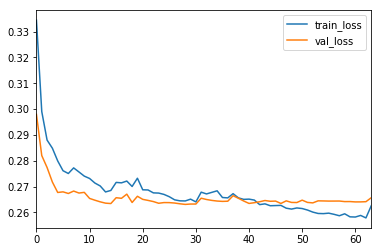

In [18]:
_ = log.plot()

## Evaluation

There is, currently, limited support for competing risks in `pycox`, so the evaluation here is just illustrative and should not be considered *best practice*.

The survival function obtained with `predict_survival_function` is the probability of surviving any of the events, and does, therefore, not distinguish between the event types.
This means that we evaluate this "single-event case" as before.

In [19]:
surv = pd.DataFrame(model.predict_survival_function(x_test), index=labtrans.cuts)
ev = EvalSurv(surv, durations_test, events_test != 0, censor_surv='km')

In [20]:
ev.concordance_td()

0.7248990344534886

In [21]:
ev.integrated_brier_score(np.linspace(0, durations_test.max(), 100))

0.09806934840592109

## The cumulative incidence function

The cumulative incidence function, or CIF, is commonly used in settings with competing risks.
We can evaluate the case-specific concordance using these CIF's.

We use `1 - cif` here because the CIF increases with with risk (while the survival function decreases with higher risk).

In [22]:
cif = model.predict_cif(x_test)
cif1 = pd.DataFrame(cif[0], index=labtrans.cuts)
cif2 = pd.DataFrame(cif[1], index=labtrans.cuts)

In [23]:
ev1 = EvalSurv(1-cif1, durations_test, events_test == 1, censor_surv='km')
ev2 = EvalSurv(1-cif2, durations_test, events_test == 2, censor_surv='km')

In [24]:
ev1.concordance_td()

0.7318759371238306

In [25]:
ev2.concordance_td()

0.7312368150083639

## Plot CIF

Finally, we plot six random individuals and their cumulative incidence functions

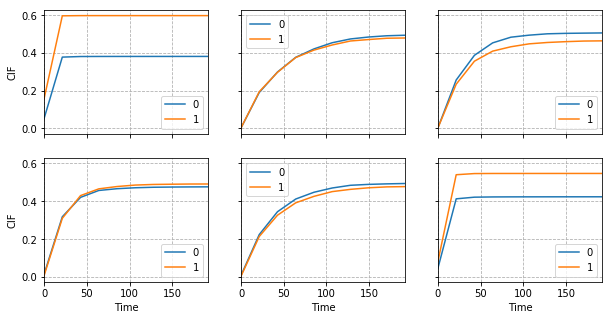

In [26]:
sample = np.random.choice(len(durations_test), 6)
fig, axs = plt.subplots(2, 3, True, True, figsize=(10, 5))
for ax, idx in zip(axs.flat, sample):
    pd.DataFrame(cif.transpose()[idx], index=labtrans.cuts).plot(ax=ax)
    ax.set_ylabel('CIF')
    ax.set_xlabel('Time')
    ax.grid(linestyle='--')